## Data and SNR Plots
This notebook was used to create Figures 1 and 4, which show examples of tetromino data across all scenarios for both classes, and an example across four signal-to-noise ratios respectively 

In [23]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import random
import pickle as pkl

from math import floor
import torch
from scipy.ndimage import gaussian_filter

from PIL import Image
from glob import glob

from pathlib import Path

np.random.seed(2023)
random.seed(2023)

In [17]:
## ./data/tetris_utils.py functions

def normalise_data(patterns, backgrounds):
    patterns /= np.linalg.norm(patterns, ord='fro')
    d_norm = np.linalg.norm(backgrounds, ord='fro')
    distractor_term = backgrounds if 0 == d_norm else backgrounds / d_norm
    return patterns, distractor_term

def scale_to_bound(row, bound):
    scale = bound / np.max(np.abs(row))
    return row * scale

def generate_background():
    sample = np.random.normal(0, 1, size=[64,64])
    return sample

def get_patterns(params):
    manip = params['manipulation']
    scale = params['pattern_scale']
    t = np.array([
            [manip,0],
            [manip,manip],
            [manip,0]
        ])
    
    l = np.array([
            [manip,0],
            [manip,0],
            [manip,manip]
        ])
    
    pattern_dict = {
        't': np.kron(t, np.ones((scale,scale))),
        'l': np.kron(l, np.ones((scale,scale))),
    }

    chosen_patterns = []
    for pattern_name in params['patterns']:
        chosen_patterns.append(pattern_dict[pattern_name])
    return chosen_patterns

positions = [[8,8],[32,40]]

def generate_linear_pattern(cls=0):
    if cls == 0:
        params = {"patterns": ["t"]}
    else:
        params = {"patterns": ["l"]}
    params['manipulation_type'] = 'additive'
    params['manipulation'] = 1.0
    params['pattern_scale'] = 8
    chosen_pattern = get_patterns(params)
    
    pos = positions[cls]

    pattern = np.zeros((64,64))
    pattern[pos[0]:pos[0]+chosen_pattern[0].shape[0], pos[1]:pos[1]+chosen_pattern[0].shape[1]] = chosen_pattern[0]
    
    return gaussian_filter(pattern, 1.5)

def generate_multiplicative_pattern(cls=0, snr=0.2):
    if cls == 0:
        params = {"patterns": ["t"]}
    else:
        params = {"patterns": ["l"]}

    params['manipulation_type'] = 'additive'
    params['pattern_scale'] = 8
    params['manipulation'] = 1.0

    chosen_pattern = get_patterns(params)
    
    pos = positions[cls]
    pattern = np.zeros((64,64))
    pattern[pos[0]:pos[0]+chosen_pattern[0].shape[0], pos[1]:pos[1]+chosen_pattern[0].shape[1]] = chosen_pattern[0]
    
    return gaussian_filter(pattern, 1.5)

def generate_translations_rotations_pattern(cls=0):
    if cls == 0:
        params = {"patterns": ["t"]}
    else:
        params = {"patterns": ["l"]}
    params['manipulation_type'] = 'additive'
    params['manipulation'] = 1.0
    params['pattern_scale'] = 4
    pattern = get_patterns(params)[0]
    pattern_adj = pattern
    rand = np.random.randint(0, high=4)
    if rand == 1:
        pattern_adj = np.rot90(pattern)
    elif rand == 2:
        pattern_adj = np.rot90(np.rot90(pattern))
    elif rand == 3:
        pattern_adj = np.rot90(np.rot90(np.rot90(pattern)))
    
    rand_y = np.random.randint(0, high= 64-pattern_adj.shape[0])
    rand_x = np.random.randint(0, high= 64-pattern_adj.shape[1])
    pos = (rand_y, rand_x)

    pattern = np.zeros((64,64))
    pattern[pos[0]:pos[0]+pattern_adj.shape[0], pos[1]:pos[1]+pattern_adj.shape[1]] = pattern_adj
    
    return gaussian_filter(pattern, 1.5)

def generate_xor_pattern(cls=0):
    params = {"patterns": ["t","l"]}
    params['manipulation_type'] = 'additive'
    params['manipulation'] = 1.0
    params['pattern_scale'] = 8
    chosen_patterns  = get_patterns(params)
    adj_signs = [-1, 1]
    poses = positions

    pattern = np.zeros((64,64))

    if cls == 0:
        rand_sign = random.sample(adj_signs, 1)
        pattern[poses[0][0]:poses[0][0]+chosen_patterns[0].shape[0], poses[0][1]:poses[0][1]+chosen_patterns[0].shape[1]] = chosen_patterns[0] * rand_sign
        pattern[poses[1][0]:poses[1][0]+chosen_patterns[1].shape[0], poses[1][1]:poses[1][1]+chosen_patterns[1].shape[1]] = chosen_patterns[1] * rand_sign
    else:
        rand_signs = random.sample(adj_signs, 2)
        pattern[poses[0][0]:poses[0][0]+chosen_patterns[0].shape[0], poses[0][1]:poses[0][1]+chosen_patterns[0].shape[1]] = chosen_patterns[0] * rand_signs[0]
        pattern[poses[1][0]:poses[1][0]+chosen_patterns[1].shape[0], poses[1][1]:poses[1][1]+chosen_patterns[1].shape[1]] = chosen_patterns[1] * rand_signs[1]
    
    return gaussian_filter(pattern, 1.5)


In [18]:
def generate_imagenet(sample_size: int) -> np.array:
    image_paths = glob(f'../imagenet_images/*')
    backgrounds = np.zeros((sample_size, 64*64))
    new_width, new_height = 64,64
    i = 0
    for image_path in random.sample(image_paths, sample_size+100):
        if i == sample_size:
            return backgrounds
        img = Image.open(image_path)
        
        width, height = img.size   # Get dimensions
        if width < 64 or height < 64:
            continue

        if height <= width:
            scale_factor=64/height
        else:
            scale_factor = 64/width
                                                    
        resize = (int(scale_factor*width),int(scale_factor*height))

        img = img.resize(resize)
        width, height = img.size

        left = round((width - new_width)/2)
        top = round((height - new_height)/2)
        x_right = round(width - new_width) - left
        x_bottom = round(height - new_height) - top
        right = width - x_right
        bottom = height - x_bottom

        # Crop the center of the image
        img = img.crop((left, top, right, bottom))

        if img.mode != 'RGB':
            img = img.convert('RGB')
        grey = np.dot(np.array(img)[...,:3], [0.299, 0.587, 0.114]).reshape((64*64))
        #print(grey.shape)
        #print(backgrounds.shape)
        #print(backgrounds[i].shape)
        backgrounds[i] = grey - grey.mean()
        i+=1
    return backgrounds


In [19]:
# Show 2 examples from each (scenario, background) pair, 1 of each class
snrs = [0.5, 0.4, 0.5, 0.825, 0.825, 0.825, 0.5, 0.2, 0.5, 0.6, 0.2, 0.6]
# snrs = [0.4] * 8
def generate_n_examples(n=2, snrs=snrs):
    backgrounds = [generate_background(), generate_background()]
    smoothed_backgrounds = [gaussian_filter(backgrounds[0].copy(), 10), gaussian_filter(backgrounds[1].copy(), 10)]
    imagenet_backgrounds = [generate_imagenet(1), generate_imagenet(1)]
    
    linear_0, linear_1 = generate_linear_pattern(0), generate_linear_pattern(1)
    mult_0, mult_1 = generate_multiplicative_pattern(0, snr=0.725), generate_multiplicative_pattern(1, snr=0.725)
    tr_0, tr_1 = generate_translations_rotations_pattern(0), generate_translations_rotations_pattern(1)
    xor_0, xor_1 = generate_xor_pattern(0), generate_xor_pattern(1)
    
    patterns = {
        'Linear': [linear_0, linear_1],
        'Multiplicative': [mult_0, mult_1],
        'Translations_Rotations': [tr_0, tr_1],
        'XOR': [xor_0, xor_1]
    }
    
    backgrounds_dict = {
        'Correlated': smoothed_backgrounds,
        'Uncorrelated': backgrounds,
        'ImageNet': imagenet_backgrounds
    }
    
    keys = ['Linear Uncorrelated', 'Linear Correlated', 'Linear ImageNet', 'Multiplicative Uncorrelated', 'Multiplicative Correlated',
            'Multiplicative ImageNet', 'Translations_Rotations Uncorrelated', 'Translations_Rotations Correlated',
            'Translations_Rotations ImageNet', 'XOR Uncorrelated', 'XOR Correlated', 'XOR ImageNet']
    data_dict = {}

    output_array = []
    for snr_ind, key in enumerate(keys):
        data = np.zeros((n,4096))
        data_dict[key] = list()
        scenario, background_type = key.split(' ')
        bg = backgrounds_dict[background_type]
        ind = 0
        for j in range(2):
            for i in range(2):
                if 'XOR' in key and i == 1:
                    scalar = -1
                else:
                    scalar = 1
                pat = patterns[scenario][j] * scalar
                back = bg[i]
                if 'Multiplicative' in key:
                    pat_copy = 1 - snrs[snr_ind] * pat.copy()
                else:
                    pat_copy = pat.copy()
                
                normalised_patterns, normalised_backgrounds = normalise_data(np.reshape(pat_copy,(64,64)), np.reshape(back, (64,64)))
                if 'Multiplicative' in key:
                    data[ind] = np.reshape( normalised_patterns * normalised_backgrounds, (4096))
                else:
                    data[ind] = np.reshape(snrs[snr_ind] * normalised_patterns + (1 - snrs[snr_ind]) * normalised_backgrounds, (4096))
                data[ind] = scale_to_bound(data[ind], 1)
                output_array.append(data[ind])
                ind += 1
        data_dict[key] += [data]
                
            
    output_dict = {}
    for key, value in data_dict.items():
        output_dict[key] = np.vstack(value)
    return output_dict, output_array

In [20]:
data_dict, data_array = generate_n_examples(n=4)

<IPython.core.display.Javascript object>


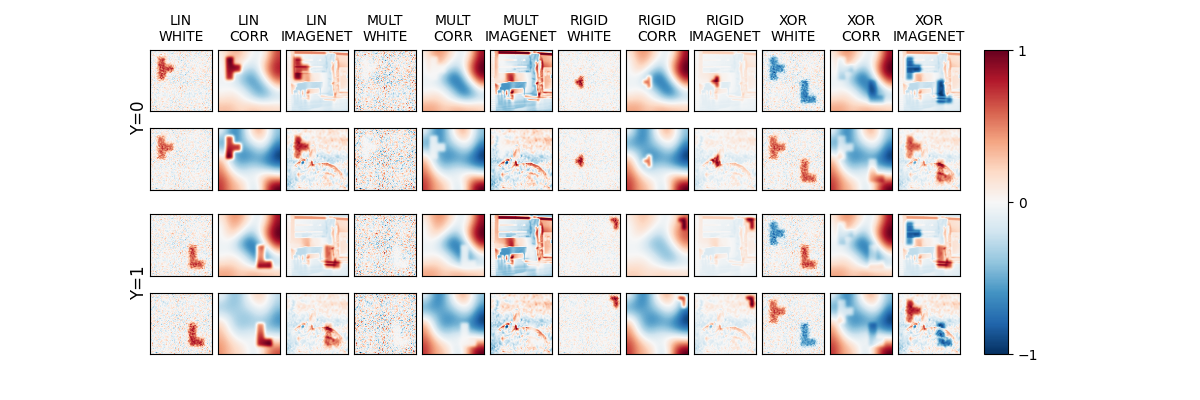

C:\Users\clark01\.virtualenvs\xai-synthetic-lesion-benchmark-5XZ-sXsh\lib\site-packages\ipykernel_launcher.py:48: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
C:\Users\clark01\.virtualenvs\xai-synthetic-lesion-benchmark-5XZ-sXsh\lib\site-packages\ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [24]:
rows = 2
cols = 12

fig = plt.figure(figsize=(12,4), constrained_layout=True)
# grid for pairs of subplots
grid = plt.GridSpec(rows, cols, hspace=0.15, wspace=0.1)

j = 0
keys = ['LIN WHITE', 'LIN CORR', 'LIN IMAGENET', 'MULT WHITE', 'MULT CORR',
        'MULT IMAGENET', 'RIGID WHITE', 'RIGID CORR', 'RIGID IMAGENET','XOR WHITE', 'XOR CORR', 'XOR IMAGENET']

for i in range(cols):
    # create fake subplot just to title pair of subplots

    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[i], wspace=0.1)

    ax = fig.add_subplot(gs[0])
    ax.imshow(np.reshape(data_array[j], (64,64)), cmap="RdBu_r", vmin=-1, vmax=1)
    ax.set_title(keys[i].replace(' ', '\n').replace('_', '\n'), fontdict = {'fontsize' : 10})
    
    ax2 = fig.add_subplot(gs[1], sharey=ax)
    ax2.imshow(np.reshape(data_array[j+1], (64,64)), cmap="RdBu_r", vmin=-1, vmax=1)
    
    for axs in [ax, ax2]:
        axs.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
    
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[i+12], wspace=0.1)
    
    ax3 = fig.add_subplot(gs[0])
    ax3.imshow(np.reshape(data_array[j+2], (64,64)), cmap="RdBu_r", vmin=-1, vmax=1)
    
    ax4 = fig.add_subplot(gs[1], sharey=ax3)
    im = ax4.imshow(np.reshape(data_array[j+3], (64,64)), cmap="RdBu_r", vmin=-1, vmax=1)
    
    if i == 0:
        ax.set_ylabel(f'Y=0\n', fontsize=12, y=0.7)
        ax.yaxis.set_label_coords(0.3,-0.10)
        ax3.set_ylabel(f'Y=1\n', fontsize=12, y=0.7)
        ax3.yaxis.set_label_coords(0.3, -0.10)
        
    
    j+=4
#     j+=2
    # hide ticks and labels
    for axs in [ax3, ax4]:
        axs.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

plt.subplots_adjust(wspace=0.2, hspace=0.2)  
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
fig.colorbar(im, cax=cbar_ax, ticks=[-1.0,0,1.0])

fig.tight_layout()

out_folder_path = f'./figures/'
Path(f'{out_folder_path}').mkdir(parents=True, exist_ok=True)
plt.savefig('./figures/data_plot_corrected_2.png', bbox_inches='tight', dpi=300)

In [30]:
def view_snrs(data, rows=4, cols=12, y_test='placeholder', labels='placeholder', figsize=(12,4)):

    fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    keys = ['LIN WHITE', 'LIN CORR', 'LIN IMAGENET', 'MULT WHITE', 'MULT CORR',
            'MULT IMAGENET', 'RIGID WHITE', 'RIGID CORR', 'RIGID IMAGENET','XOR WHITE', 'XOR CORR', 'XOR IMAGENET']
    
    for j, scenario in enumerate(list(data.keys())):
        axs[0,j].set_title(keys[j].replace(' ', '\n'), fontdict = {'fontsize' : 10})
        for i in range(rows):
            axs[i,0].set_ylabel(str(chosen_snrs[i]), fontdict = {'fontsize' : 11})
            axs[i,0].yaxis.set_label_coords(0,0.5)
            axs[i,j].imshow(np.reshape(data[scenario][i],(64,64)), cmap="RdBu_r", vmin=-1, vmax=1)   
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
    fig.suptitle('$\\alpha$', fontweight='semibold', size=20, x=0.1, y=0.52, rotation=90)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.115, 0.02, 0.76])
    fig.colorbar(im, cax=cbar_ax, ticks=[-1.0,0,1.0])
    out_folder_path = f'./figures/'
    Path(f'{out_folder_path}').mkdir(parents=True, exist_ok=True)
    plt.savefig('./figures/snr_plot.png', bbox_inches='tight', dpi=300)
    plt.show()

In [31]:
background = generate_background()
smoothed_background = gaussian_filter(background.copy(), 10)
imagenet_background = generate_imagenet(1)

linear = generate_linear_pattern(1)
multiplicative = generate_multiplicative_pattern(1)
tr = generate_translations_rotations_pattern(1)
xor = generate_xor_pattern(1)

backgrounds = [background,smoothed_background, imagenet_background]
keys = ['LIN WHITE', 'LIN CORR', 'LIN IMAGENET', 'MULT WHITE', 'MULT CORR',
            'MULT IMAGENET', 'RIGID WHITE', 'RIGID CORR', 'RIGID IMAGENET','XOR WHITE', 'XOR CORR', 'XOR IMAGENET']
patterns = {
    'LIN': linear,
    'MULT': multiplicative,
    'RIGID': tr,
    'XOR': xor
}

chosen_snrs = [0.05, 0.3, 0.55, 0.8]
data_dict = {}
for i, key in enumerate(keys):
    data_dict[keys[i]] = np.zeros((4,4096))
    data = np.zeros((4,4096))
    scenario, background_type = key.split(' ')
    for j, snr in enumerate(chosen_snrs):

        pat = patterns[scenario]
        
        if background_type == 'CORR':
            back = backgrounds[1]
        elif background_type == 'IMAGENET':
            back = backgrounds[2]
        else:
            back = backgrounds[0]
   
        if 'MULT' in key:
            pat_copy = 1 - snr * pat.copy()
        else:
            pat_copy = pat.copy()

        normalised_patterns, normalised_backgrounds = normalise_data(np.reshape(pat_copy,(64,64)), np.reshape(back, (64,64)))
        if 'MULT' in key:
            data[j] = np.reshape( normalised_patterns * normalised_backgrounds, (4096))
        else:
            data[j] = np.reshape(snr * normalised_patterns + (1 - snr) * normalised_backgrounds, (4096))
  
        data[j] = scale_to_bound(data[j], 1)
    data_dict[key] = data

<IPython.core.display.Javascript object>


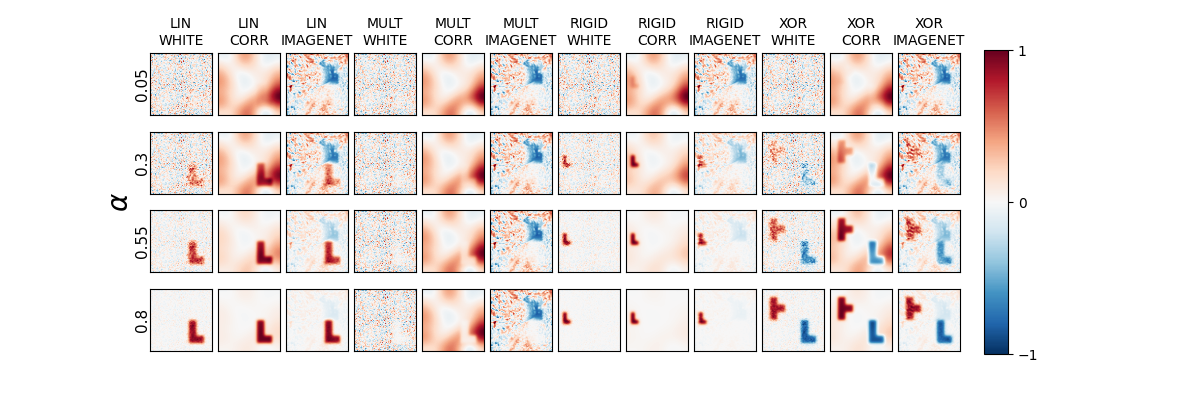

C:\Users\clark01\.virtualenvs\xai-synthetic-lesion-benchmark-5XZ-sXsh\lib\site-packages\ipykernel_launcher.py:16: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


In [32]:
view_snrs(data_dict)